In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
import datetime
import pandas as pd
%matplotlib inline

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

2.8.0


In [2]:
TS_Data = pd.read_csv("TS_data.csv")
RF_Data = pd.read_csv("RF_data.csv")

In [3]:
TS_Data

,Unnamed: 0,Description,Dates,Quantity
0,0,ALARM CLOCK BAKELIKE RED,2010-12-01,19.0
1,1,ALARM CLOCK BAKELIKE RED,2010-12-02,88.0
2,2,ALARM CLOCK BAKELIKE RED,2010-12-03,51.0
3,3,ALARM CLOCK BAKELIKE RED,2010-12-04,0.0
4,4,ALARM CLOCK BAKELIKE RED,2010-12-05,38.0
...,...,...,...,...
5605,5605,WOODEN PICTURE FRAME WHITE FINISH,2011-12-05,15.0
5606,5606,WOODEN PICTURE FRAME WHITE FINISH,2011-12-06,8.0
5607,5607,WOODEN PICTURE FRAME WHITE FINISH,2011-12-07,42.0
5608,5608,WOODEN PICTURE FRAME WHITE FINISH,2011-12-08,10.0


In [4]:
RF_Data

,Unnamed: 0,Description,Dates,Quantity,Invoice,CustomerID,Total_Price,Relative_UnitPrice
0,0,ALARM CLOCK BAKELIKE RED,2010-12-01,19.0,3,3,78.99,4.157368
1,1,ALARM CLOCK BAKELIKE RED,2010-12-02,88.0,6,6,330.00,3.750000
2,2,ALARM CLOCK BAKELIKE RED,2010-12-03,51.0,2,2,205.41,4.027647
3,3,ALARM CLOCK BAKELIKE RED,2010-12-04,0.0,0,0,0.00,0.000000
4,4,ALARM CLOCK BAKELIKE RED,2010-12-05,38.0,7,7,142.50,3.750000
...,...,...,...,...,...,...,...,...
5605,5605,WOODEN PICTURE FRAME WHITE FINISH,2011-12-05,15.0,6,4,71.69,4.779333
5606,5606,WOODEN PICTURE FRAME WHITE FINISH,2011-12-06,8.0,3,3,26.44,3.305000
5607,5607,WOODEN PICTURE FRAME WHITE FINISH,2011-12-07,42.0,6,6,131.94,3.141429
5608,5608,WOODEN PICTURE FRAME WHITE FINISH,2011-12-08,10.0,3,3,35.53,3.553000


In [5]:
Dates = TS_Data["Dates"].unique()

In [6]:
Products = ['WHITE HANGING HEART T-LIGHT HOLDER',
 'REGENCY CAKESTAND 3 TIER',
 'JUMBO BAG RED RETROSPOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'NATURAL SLATE HEART CHALKBOARD ']

In [7]:
TS_Prod = {}
RF_Prod = {}
for product in Products:
    TS_Prod[product] = np.array(TS_Data[TS_Data["Description"] == product]["Quantity"])
    RF_Prod[product] = RF_Data[RF_Data["Description"] == product][["Total_Price"]]

In [8]:
def windowed_dataset(series, window_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    #dataset = dataset.batch(batch_size).prefetch(1)
    return zip(*list(dataset.as_numpy_iterator()))

In [9]:
def createmodel(n_layers = 2, activation_func = "linear", opt = "sgd"):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]))
    for i in range(n_layers):
        if i!= n_layers - 1:
            model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
        else:
            model.add(keras.layers.Bidirectional(tf.keras.layers.LSTM(50)))
            
    model.add(keras.layers.Dense(1, activation=activation_func))
    model.add(keras.layers.Lambda(lambda x: x * 100.0))
    model.compile(optimizer = opt, loss='huber_loss', metrics = ["mae"]) 
    
    return model

model =  KerasRegressor(model=createmodel,n_layers = 2, activation_func = "linear", opt = "sgd",verbose=False,random_state=0)  

In [10]:
activation_funcs = ['linear']#, 'relu', 'tanh'] 
optimizers = ["rmsprop"]#, "adam", "sgd"]
param_grid = {"n_layers":[2], "activation_func" : activation_funcs, "opt" : optimizers, "batch_size" : [5], "epochs" : [100]}
cv = ShuffleSplit(n_splits=1, test_size=0.09, random_state=0)
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=cv)

In [11]:
window_size = 31
shuffle_buffer = 342
model_hp = {'Product': [],'activation_func': [],
 'batch_size': [],
 'epochs': [],
 'n_layers': [],
 'opt': []}
for product in Products[:1]:
    train = TS_Prod[product][:-window_size]
    X, y = windowed_dataset(train,window_size,shuffle_buffer)

    grid.fit(np.array(X),np.array(y))

    best = dict(grid.best_params_)
    model_hp['Product'].append(product)
    for key in best.keys() :
        model_hp[key].append(best[key])


pd.DataFrame(model_hp).to_csv("hyperparameters.csv",index=False)

In [12]:
grid.best_estimator_

KerasRegressor(
	model=<function createmodel at 0x0000017A8D7E5430>
	build_fn=None
	warm_start=False
	random_state=0
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=False
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	n_layers=2
	activation_func=linear
	opt=rmsprop
)

print(model)
model.activation_func = 'linear'
model.batch_size =  5
model.n_layers = 3
model.epochs = 100
model.opt = 'sgd'

model

train = TS_Prod[Products[0]][:-window_size]
X, y = windowed_dataset(train,window_size,shuffle_buffer)
model.fit(X,y)

In [13]:
forecast = []
for time in range(len(train) - window_size):
    forecast.append(grid.best_estimator_.predict(train[time:time+window_size][np.newaxis]))

In [14]:
pred = np.array(list(zip(*forecast))[0])

In [15]:
len(pred)

312

In [16]:
test_predLSTM = []
for time in range(len(TS_Prod[Products[0]]) - 2*window_size,len(TS_Prod[Products[0]]) - window_size):
    test_predLSTM.append(grid.best_estimator_.predict(TS_Prod[Products[0]][time:time+window_size][np.newaxis]))

In [17]:
len(test_predLSTM)

31

In [18]:
test_predLSTM = np.array(list(zip(*test_predLSTM))[0])

In [19]:
test_actual = TS_Prod[Products[0]][-window_size:]

68.36737306656376


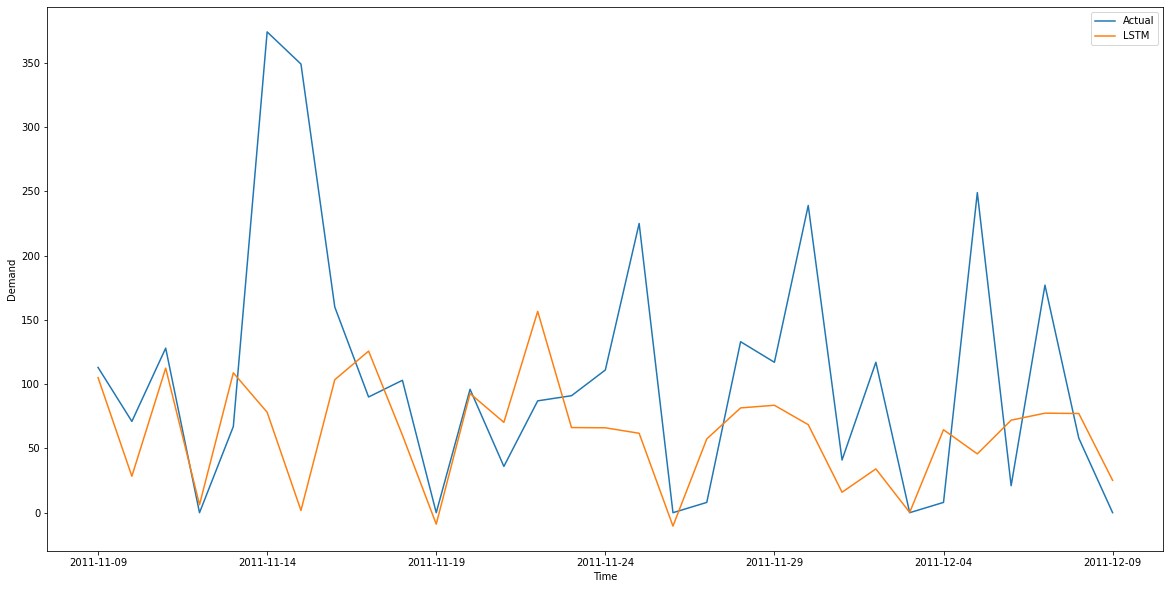

In [20]:
plt.figure(figsize=(20,10))
plt.plot(Dates[-window_size:],test_actual, label="Actual")
plt.plot(Dates[-window_size:],test_predLSTM, label="LSTM")
dates = [Dates[-window_size + i*5] for i in range(window_size//5 + 1)]
plt.xticks(dates)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Demand")
print(np.sum(abs(test_actual - test_predLSTM)) / test_actual.shape[0])

In [21]:
actual_train = train[window_size:]

In [22]:
actual_train

array([0.000e+00, 0.000e+00, 0.000e+00, 6.700e+01, 3.040e+02, 1.710e+02,
       3.280e+02, 0.000e+00, 9.700e+01, 1.200e+01, 3.114e+03, 8.300e+01,
       8.000e+00, 8.900e+01, 0.000e+00, 2.300e+01, 2.200e+02, 1.800e+01,
       1.500e+01, 3.600e+01, 6.400e+01, 0.000e+00, 4.700e+01, 5.000e+00,
       7.900e+01, 1.830e+02, 6.400e+01, 6.800e+01, 0.000e+00, 1.230e+02,
       3.100e+01, 1.890e+02, 2.220e+02, 3.100e+01, 4.200e+01, 0.000e+00,
       3.500e+01, 6.100e+01, 1.530e+02, 8.000e+00, 6.600e+01, 2.090e+02,
       0.000e+00, 6.000e+00, 6.600e+01, 1.200e+01, 1.710e+02, 4.400e+01,
       6.000e+00, 0.000e+00, 2.800e+01, 1.700e+01, 9.600e+01, 8.400e+01,
       6.300e+01, 4.000e+01, 0.000e+00, 2.700e+01, 3.700e+01, 8.000e+01,
       3.300e+01, 9.600e+01, 2.100e+01, 0.000e+00, 1.010e+02, 2.600e+01,
       1.450e+02, 8.600e+01, 4.500e+01, 1.250e+02, 0.000e+00, 3.000e+00,
       1.900e+01, 9.600e+01, 1.410e+02, 8.700e+01, 5.700e+01, 0.000e+00,
       4.700e+01, 3.800e+01, 7.200e+01, 8.300e+01, 

In [23]:
len(actual_train)

312

In [24]:
residuals = actual_train - pred

In [25]:
np.sum(abs(residuals))/residuals.shape[0]

29.594717514438507

In [26]:
RF_Data = RF_Prod[Products[0]][window_size:][:-window_size]

In [27]:
rf = RandomForestRegressor(n_estimators=514,max_depth=40,criterion='absolute_error',random_state=0)

In [28]:
reg = rf.fit(RF_Data,residuals)

In [29]:
reg.score(RF_Data,residuals)

0.9664921448699405

In [30]:
reg.score(RF_Data,residuals)

0.9664921448699405

In [31]:
train_predRF = reg.predict(RF_Data)

In [32]:
sum(abs(train_predRF-residuals))/len(train_predRF)

10.094717477383709

In [33]:
#residuals

In [34]:
RF_test = RF_Prod[Products[0]][-window_size:]

In [35]:
test_predRF = reg.predict(RF_test)

In [36]:
test_pred = test_predLSTM + test_predRF
test_pred[test_pred<0] = 0

58.83389686935144


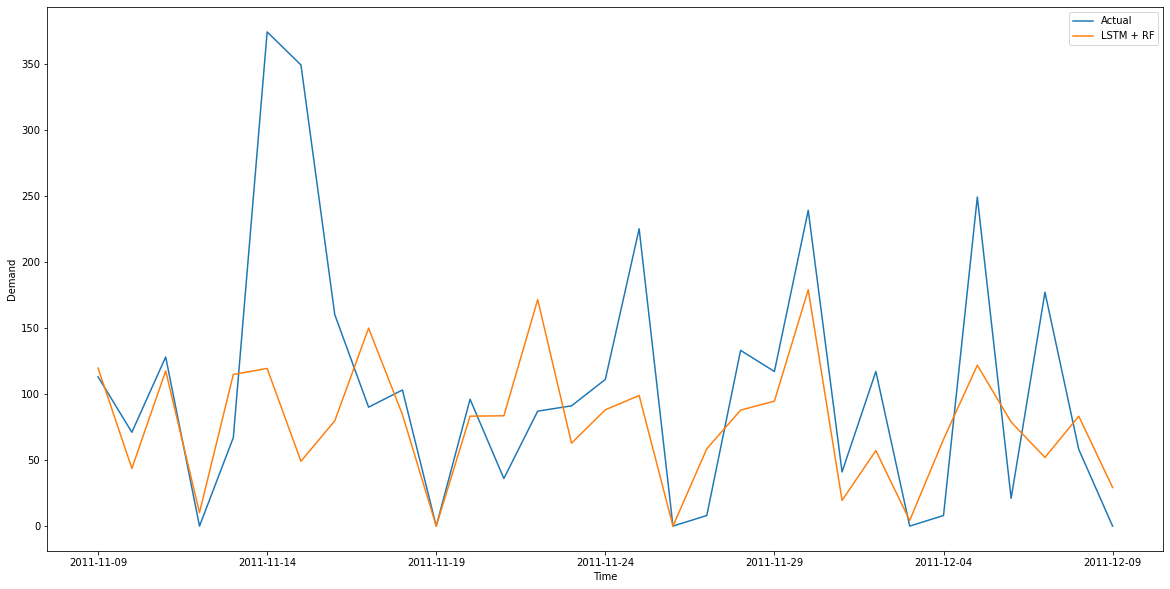

In [37]:
plt.figure(figsize=(20,10))
plt.plot(Dates[-window_size:],test_actual, label="Actual")
plt.plot(Dates[-window_size:],test_pred, label="LSTM + RF")
dates = [Dates[-window_size + i*5] for i in range(window_size//5 + 1)]
plt.xticks(dates)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Demand")
print(np.sum(abs(test_actual - test_pred)) / test_actual.shape[0])

In [38]:
test_actual

array([113.,  71., 128.,   0.,  67., 374., 349., 160.,  90., 103.,   0.,
        96.,  36.,  87.,  91., 111., 225.,   0.,   8., 133., 117., 239.,
        41., 117.,   0.,   8., 249.,  21., 177.,  58.,   0.])

In [39]:
test_pred

array([119.56635458,  43.66290779, 117.42993364,  10.20937335,
       114.77200457, 119.29991505,  49.07033452,  79.66549227,
       149.8217721 ,  84.43718577,   0.        ,  83.19141321,
        83.48624966, 171.39723703,  62.76223694,  87.99066699,
        98.83842231,   0.        ,  58.5274899 ,  87.75520381,
        94.57143194, 178.87255325,  19.47153284,  57.13923028,
         4.22341919,  65.63406109, 121.75324273,  78.73171031,
        51.96313362,  83.15894058,  29.19702756])

58.83389686935144


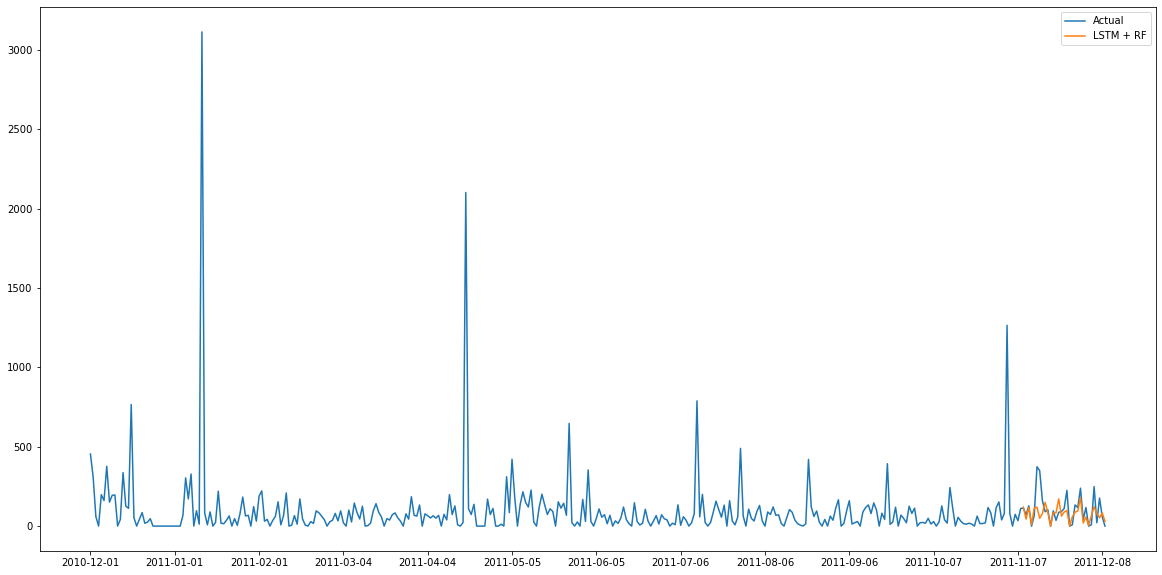

In [40]:
plt.figure(figsize=(20,10))
plt.plot(Dates,TS_Prod[Products[0]], label="Actual")
plt.plot(Dates[-window_size:],test_pred, label="LSTM + RF")#dates = [Dates[-window_size + i*5] for i in range(window_size//5 + 1)]
plt.xticks(Dates[::31])
plt.legend()
print(np.sum(abs(test_actual - test_pred)) / test_actual.shape[0])